# DS100 Final Project
## Basketball Data Analysis
### Team: Alec Zhou, Jahnvi Doshi, Prashant Malyala

Below, we will import the necessary libraries for our data analysis.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Now, we'll read in the relevant basketball data.

In [2]:
#personally im thinking team box score and standings are the move
box_scores = pd.read_csv('basketball/Basketball-BoxScores.csv')
player_box_score = pd.read_csv('basketball/Basketball-PlayerBoxScore.csv')
team_box_score = pd.read_csv('basketball/Basketball-TeamBoxScores.csv')
college = pd.read_csv('basketball/college.csv')
standings = pd.read_csv('basketball/Standings.csv')

## This Project

Briefly explain the question we're trying to answer. This will be detailed in our paper but would also be useful to quickly mention here to enhance the clarity of our notebook code.

## Exploratory Data Analysis, Data Cleaning

We'll use the following section to explore and understand the data and analyze potential trends that could be of use in our analysis.

### NOTE: There are 2 rows per game in this dataset. Aka one row for Was vs Cle and another row for Cle vs Was on the same day

In [60]:
team_box_score.shape

(14758, 123)

In [59]:
team_box_score[team_box_score['gmDate'] == '2012-10-30'][['teamAbbr', 'opptAbbr']]

,teamAbbr,opptAbbr
0,WAS,CLE
1,CLE,WAS
2,BOS,MIA
3,MIA,BOS
4,DAL,LAL
5,LAL,DAL


In [32]:
tbs_cleaned = team_box_score.drop(['offLNm1', 'offFNm1', 'offLNm2', 'offFNm2', 'offLNm3', 'offFNm3',
                                  'teamConf', 'teamDiv', 'teamMin', 'teamDayOff', 'gmTime', 'seasTyp', 'gmDate'], axis=1)

In [33]:
tbs_cleaned = tbs_cleaned.replace(to_replace=['Loss', 'Win'], value=[0, 1])
tbs_cleaned.head()

,teamAbbr,teamLoc,teamRslt,teamPTS,teamAST,teamTO,teamSTL,teamBLK,teamPF,teamFGA,...,opptFIC40,opptOrtg,opptDrtg,opptEDiff,opptPlay%,opptAR,opptAST/TO,opptSTL/TO,poss,pace
0,WAS,Away,0,84,26,13,11,10,19,90,...,61.6667,105.6882,94.4447,11.2435,0.4390,16.7072,1.0476,33.3333,88.9409,88.9409
1,CLE,Home,1,94,22,21,7,5,21,79,...,56.0417,94.4447,105.6882,-11.2435,0.3765,18.8679,2.0000,84.6154,88.9409,88.9409
2,BOS,Away,0,107,24,16,4,2,23,75,...,80.8333,126.3381,112.6515,13.6866,0.5244,19.8287,3.1250,100.0000,94.9832,94.9832
3,MIA,Home,1,120,25,8,8,5,20,79,...,62.7083,112.6515,126.3381,-13.6866,0.4643,18.8501,1.5000,25.0000,94.9832,94.9832
4,DAL,Away,1,99,22,12,9,5,25,85,...,58.6458,99.3678,108.1034,-8.7356,0.5000,18.6567,1.7143,42.8571,91.5790,91.5790


In [71]:
np.var(tbs_cleaned).sort_values(ascending=False)[0:25]

teamSTL/TO    811.425119
opptSTL/TO    811.425119
teamFIC       263.746870
opptFIC       263.746870
teamEDiff     207.632353
opptEDiff     207.632353
teamFIC40     180.452726
opptFIC40     180.452726
opptPTS       149.379670
teamPTS       149.379670
opptOrtg      127.827859
opptDrtg      127.827859
teamOrtg      127.827859
teamDrtg      127.827859
teamASST%     104.703216
opptASST%     104.703216
team2PA        73.983375
oppt2PA        73.983375
opptMin        58.026938
teamOREB%      57.578242
teamDREB%      57.578242
opptOREB%      56.687440
opptDREB%      56.687440
teamFTA        55.092234
opptFTA        55.092234
dtype: float64

In [42]:
numbers_only = tbs_cleaned.drop(['teamAbbr', 'teamLoc', 'opptAbbr', 'opptConf', 'opptDiv', 'opptLoc', 'opptRslt'], axis=1)

In [45]:
#centers data mean on 0, can now do SVD
numbers_only_centered = numbers_only - np.mean(numbers_only)
numbers_only_centered.head()

,teamRslt,teamPTS,teamAST,teamTO,teamSTL,teamBLK,teamPF,teamFGA,teamFGM,teamFG%,...,opptFIC40,opptOrtg,opptDrtg,opptEDiff,opptPlay%,opptAR,opptAST/TO,opptSTL/TO,poss,pace
0,-0.5,-18.293332,3.611465,-1.3657,3.248408,5.13701,-1.129286,5.899444,-6.210394,-0.099823,...,-1.424022,-1.371071,-12.614571,11.2435,0.004022,-0.310762,-0.65363,-24.708228,-6.632805,-5.93341
1,0.5,-8.293332,-0.388535,6.6343,-0.751592,0.13701,0.870714,-5.100556,-2.210394,0.000277,...,-7.049022,-12.614571,-1.371071,-11.2435,-0.058478,1.849938,0.29877,26.573872,-6.632805,-5.93341
2,-0.5,4.706668,1.611465,1.6343,-3.751592,-2.86299,2.870714,-9.100556,0.789606,0.064577,...,17.742578,19.278829,5.592229,13.6866,0.089422,2.810738,1.42377,41.958472,-0.590505,0.10889
3,0.5,17.706668,2.611465,-6.3657,0.248408,0.13701,-0.129286,-5.100556,4.789606,0.088877,...,-0.382422,5.592229,19.278829,-13.6866,0.029322,1.832138,-0.20123,-33.041528,-0.590505,0.10889
4,0.5,-3.293332,-0.388535,-2.3657,1.248408,0.13701,4.870714,0.899444,1.789606,0.015177,...,-4.444922,-7.691471,1.044129,-8.7356,0.065022,1.638738,0.01307,-15.184428,-3.994705,-3.29531


In [48]:
#divide by standard deviation to prevent high variance components from affecting PCA
numbers_only_centered_scaled = np.divide(numbers_only_centered, np.sqrt(np.var(numbers_only_centered)))
numbers_only_centered_scaled.head()

,teamRslt,teamPTS,teamAST,teamTO,teamSTL,teamBLK,teamPF,teamFGA,teamFGM,teamFG%,...,opptFIC40,opptOrtg,opptDrtg,opptEDiff,opptPlay%,opptAR,opptAST/TO,opptSTL/TO,poss,pace
0,-1.0,-1.496742,0.711431,-0.349790,1.110877,1.993406,-0.260418,0.812733,-1.236110,-1.808219,...,-0.106007,-0.121268,-1.115732,0.780286,0.077499,-0.095765,-0.921112,-0.867396,-1.140280,-1.149252
1,1.0,-0.678552,-0.076538,1.699211,-0.257026,0.053167,0.200790,-0.702674,-0.439954,0.005013,...,-0.524744,-1.115732,-0.121268,-0.780286,-1.126717,0.570082,0.421034,0.932890,-1.140280,-1.149252
2,-1.0,0.385095,0.317446,0.418585,-1.282954,-1.110977,0.661999,-1.253731,0.157162,1.169757,...,1.320794,1.705171,0.494621,0.949835,1.722940,0.866164,2.006412,1.472975,-0.101517,0.021091
3,1.0,1.448742,0.514439,-1.630415,0.084949,0.053167,-0.029814,-0.702674,0.953318,1.609932,...,-0.028468,0.494621,1.705171,-0.949835,0.564966,0.564596,-0.283578,-1.159941,-0.101517,0.021091
4,1.0,-0.269457,-0.076538,-0.605915,0.426925,0.053167,1.123207,0.123911,0.356201,0.274915,...,-0.330889,-0.680294,0.092351,-0.606241,1.252814,0.504998,0.018418,-0.533058,-0.686750,-0.638274


In [53]:
u, s, vt = np.linalg.svd(numbers_only_centered_scaled, full_matrices=False)
p_matrix = numbers_only_centered_scaled @ vt.T

Text(0.5, 1.0, 'Scree Plot of Variance of PC #i')

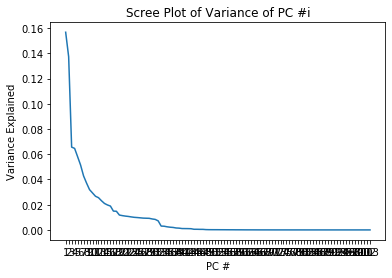

In [54]:
plt.plot(np.arange(1, 104), s**2 / sum(s**2));
plt.xticks(np.arange(1, 104), np.arange(1, 104));
plt.xlabel('PC #');
plt.ylabel('Variance Explained');
plt.title('Scree Plot of Variance of PC #i')

In [72]:
numbers_only_filtered = numbers_only[numbers_only.columns.drop(list(numbers_only.filter(regex='oppt')))]

df_rando = numbers_only_filtered[['teamOREB%', 'teamEDiff', 'teamSTL', 'teamBLK', 'teamFG%', 'team3P%', 'teamORB',
                                 'teamDRB', 'teamPTS3', 'teamPTS4', 'teamASST%', 'teamEFG%', 'teamOrtg', 'teamDrtg',
                                 'teamSTL/TO']]
df_rando.head()

,teamOREB%,teamEDiff,teamSTL,teamBLK,teamFG%,team3P%,teamORB,teamDRB,teamPTS3,teamPTS4,teamASST%,teamEFG%,teamOrtg,teamDrtg,teamSTL/TO
0,33.3333,-11.2435,11,10,0.3556,0.2500,18,21,23,22,81.2500,0.4000,94.4447,105.6882,84.6154
1,46.1538,11.2435,7,5,0.4557,0.3500,18,36,24,20,61.1111,0.5000,105.6882,94.4447,33.3333
2,18.4211,-13.6866,4,2,0.5200,0.4615,7,34,22,31,61.5385,0.5600,112.6515,126.3381,25.0000
3,12.8205,13.6866,8,5,0.5443,0.5000,5,31,31,27,58.1395,0.5949,126.3381,112.6515,100.0000
4,22.5000,8.7356,9,5,0.4706,0.3333,9,31,26,25,55.0000,0.5000,108.1034,99.3678,75.0000


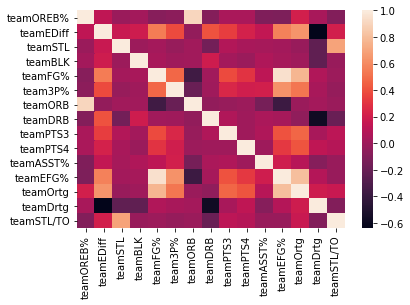

In [73]:
sns.heatmap(df_rando.corr())

## Inference and Prediction